In [ ]:
#!pip install plotly

In [79]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from datetime import date
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from prophet.serialize import model_to_json, model_from_json
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [106]:
url = 'C:/Users/Ula/Documents/InfoShareAcademy/PROJEKT_3/ml_projekt' 
#url = 'C:/Users/plhurno/OneDrive - Essity/Priv/ml'
df_seasons_D = pd.read_csv(url + '/df_seasons_D_2.csv', sep=",")
df_seasons_D

,Datestamp,Global_active_power
0,2006-12-21 00:00:00,0.025598
1,2006-12-21 01:00:00,0.023299
2,2006-12-21 02:00:00,0.021248
3,2006-12-21 03:00:00,0.005043
4,2006-12-21 04:00:00,0.004112
...,...,...
32923,2010-09-22 19:00:00,0.028012
32924,2010-09-22 20:00:00,0.035645
32925,2010-09-22 21:00:00,0.026326
32926,2010-09-22 22:00:00,0.013373


In [107]:
df_seasons_D = df_seasons_D.rename(columns={'Datestamp': 'ds', 'Global_active_power': 'y'})
df_seasons_D['ds'] = pd.to_datetime(df_seasons_D['ds'])
df_seasons_D.head()

,ds,y
0,2006-12-21 00:00:00,0.025598
1,2006-12-21 01:00:00,0.023299
2,2006-12-21 02:00:00,0.021248
3,2006-12-21 03:00:00,0.005043
4,2006-12-21 04:00:00,0.004112


In [108]:
def get_season(date):
    spring_start = pd.Timestamp(date.year, 3, 21)
    summer_start = pd.Timestamp(date.year, 6, 21)
    autumn_start = pd.Timestamp(date.year, 9, 23)
    winter_start = pd.Timestamp(date.year, 12, 21)

    if date >= spring_start and date < summer_start:
        return 'is_spring'
    elif date >= summer_start and date < autumn_start:
        return 'is_summer'
    elif date >= autumn_start and date < winter_start:
        return 'is_autumn'
    else:
        return 'is_winter'

# Adding bool columns for each season:
df_seasons_D['is_spring'] = df_seasons_D['ds'].apply(lambda x: get_season(x) == 'is_spring')
df_seasons_D['is_summer'] = df_seasons_D['ds'].apply(lambda x: get_season(x) == 'is_summer')
df_seasons_D['is_autumn'] = df_seasons_D['ds'].apply(lambda x: get_season(x) == 'is_autumn')
df_seasons_D['is_winter'] = df_seasons_D['ds'].apply(lambda x: get_season(x) == 'is_winter')

# Result & checking
df_seasons_D.head()



,ds,y,is_spring,is_summer,is_autumn,is_winter
0,2006-12-21 00:00:00,0.025598,False,False,False,True
1,2006-12-21 01:00:00,0.023299,False,False,False,True
2,2006-12-21 02:00:00,0.021248,False,False,False,True
3,2006-12-21 03:00:00,0.005043,False,False,False,True
4,2006-12-21 04:00:00,0.004112,False,False,False,True


In [109]:
# Cheking correctness of data
expected_seasons = ['is_winter', 'is_spring', 'is_summer', 'is_autumn']

for expected_season in expected_seasons:
    print(f"Przyporządkowanie do {expected_season}:")
    print(df_seasons_D[df_seasons_D[expected_season]].head())
    print()

Przyporządkowanie do is_winter:
                   ds         y  is_spring  is_summer  is_autumn  is_winter
0 2006-12-21 00:00:00  0.025598      False      False      False       True
1 2006-12-21 01:00:00  0.023299      False      False      False       True
2 2006-12-21 02:00:00  0.021248      False      False      False       True
3 2006-12-21 03:00:00  0.005043      False      False      False       True
4 2006-12-21 04:00:00  0.004112      False      False      False       True

Przyporządkowanie do is_spring:
                      ds         y  is_spring  is_summer  is_autumn  is_winter
2160 2007-03-21 00:00:00  0.023272       True      False      False      False
2161 2007-03-21 01:00:00  0.022678       True      False      False      False
2162 2007-03-21 02:00:00  0.007821       True      False      False      False
2163 2007-03-21 03:00:00  0.005251       True      False      False      False
2164 2007-03-21 04:00:00  0.004733       True      False      False      False

Przy

C:\Users\Ula\AppData\Local\Temp\ipykernel_11956\2344182582.py:9: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = by_years, x = 'month', y = 'y', hue='year', ax=ax, palette=palette)


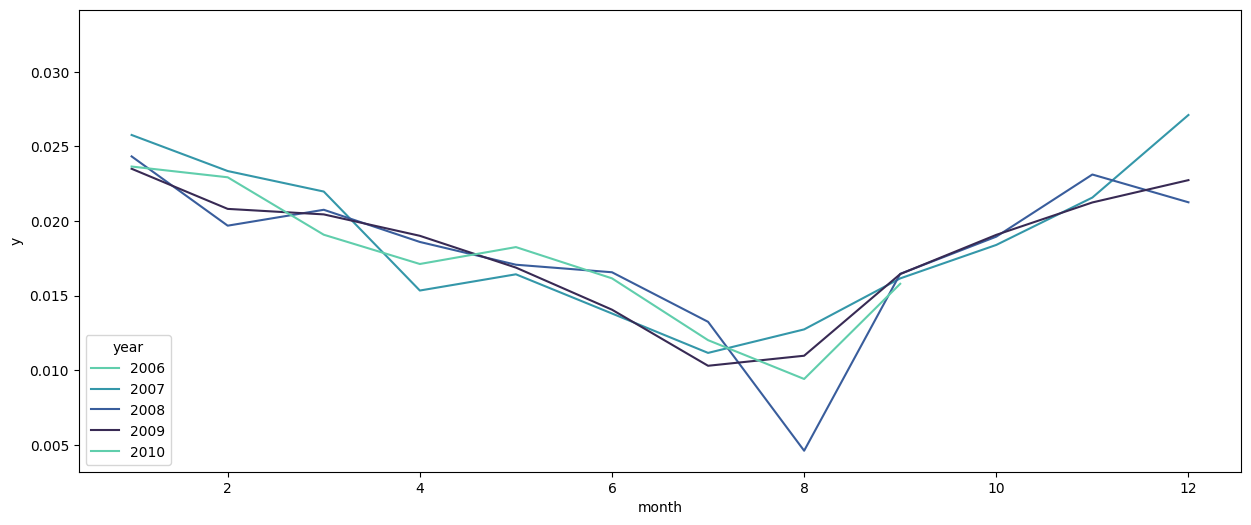

In [110]:
by_years = df_seasons_D[['ds', 'y']].copy()
by_years['year'] = by_years['ds'].dt.year
by_years['month'] = by_years['ds'].dt.month
by_years = by_years.groupby(['year', 'month'])['y'].mean().reset_index()

plt.close()
palette = sns.color_palette("mako_r", 4)
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(data = by_years, x = 'month', y = 'y', hue='year', ax=ax, palette=palette)
plt.show()

In [111]:
# train and test bases creating : 

train_seasons = df_seasons_D[(df_seasons_D['ds'] >= '2006-12-21 00:00:00') & (df_seasons_D['ds'] < '2009-12-22 00:00:00')]
test_seasons = df_seasons_D[(df_seasons_D['ds'] >= '2009-12-22 00:00:00')]


In [112]:
train_seasons.head()

,ds,y,is_spring,is_summer,is_autumn,is_winter
0,2006-12-21 00:00:00,0.025598,False,False,False,True
1,2006-12-21 01:00:00,0.023299,False,False,False,True
2,2006-12-21 02:00:00,0.021248,False,False,False,True
3,2006-12-21 03:00:00,0.005043,False,False,False,True
4,2006-12-21 04:00:00,0.004112,False,False,False,True


In [113]:
train_seasons.shape[0]

26328

In [114]:
test_seasons.head()

,ds,y,is_spring,is_summer,is_autumn,is_winter
26328,2009-12-22 00:00:00,0.006732,False,False,False,True
26329,2009-12-22 01:00:00,0.004876,False,False,False,True
26330,2009-12-22 02:00:00,0.005102,False,False,False,True
26331,2009-12-22 03:00:00,0.004571,False,False,False,True
26332,2009-12-22 04:00:00,0.004296,False,False,False,True


In [115]:
test_seasons.shape[0]

6600

In [139]:
train_seasons_mean = train_seasons.set_index('ds').resample('M').agg({'y': 'mean', 'is_spring': 'first', 'is_summer': 'first', 'is_autumn' : 'first', 'is_winter' : 'first' }).reset_index()
test_seasons_mean = test_seasons.set_index('ds').resample('M').agg({'y': 'mean', 'is_spring': 'first', 'is_summer': 'first', 'is_autumn' : 'first', 'is_winter' : 'first' }).reset_index()

In [140]:
train_seasons_mean

,ds,y,is_spring,is_summer,is_autumn,is_winter
0,2006-12-31,0.032755,False,False,False,True
1,2007-01-31,0.025768,False,False,False,True
2,2007-02-28,0.023352,False,False,False,True
3,2007-03-31,0.021977,False,False,False,True
4,2007-04-30,0.015344,True,False,False,False
5,2007-05-31,0.016431,True,False,False,False
6,2007-06-30,0.013804,True,False,False,False
7,2007-07-31,0.011164,False,True,False,False
8,2007-08-31,0.012739,False,True,False,False
9,2007-09-30,0.016157,False,True,False,False


In [141]:
train_seasons_mean.shape[0]

37

In [142]:
test_seasons_mean.head()

,ds,y,is_spring,is_summer,is_autumn,is_winter
0,2009-12-31,0.024955,False,False,False,True
1,2010-01-31,0.023653,False,False,False,True
2,2010-02-28,0.022933,False,False,False,True
3,2010-03-31,0.019084,False,False,False,True
4,2010-04-30,0.017122,True,False,False,False


In [143]:
test_seasons_mean.shape[0]

10

In [138]:
# Model creation 
model_seasons = Prophet(seasonality_mode='multiplicative',
                        growth='flat',
                        interval_width=0.8,
                        n_changepoints=25,
                        changepoint_range=0.01,
                        yearly_seasonality= 'auto',
                        weekly_seasonality= 'auto',
                        daily_seasonality = False,
                        holidays = None,
                        seasonality_prior_scale= 10,
                        holidays_prior_scale=10,
                        changepoint_prior_scale=10)

# Add each of the seasonalities
model_seasons.add_seasonality(name='winter', period=91.25,fourier_order=10, condition_name='is_winter')
model_seasons.add_seasonality(name='spring', period=91.25,fourier_order=10, condition_name='is_spring')
model_seasons.add_seasonality(name='summer', period=91.25, fourier_order=10, condition_name='is_summer')
model_seasons.add_seasonality(name='autumn', period=91.25, fourier_order=10, condition_name='is_autumn')
model_seasons.add_country_holidays(country_name='FRA')

model_seasons.fit(train_seasons)



16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing


In [144]:
future_seasons = model_seasons.make_future_dataframe(periods=275, freq = 'D', include_history=True)  # Prognoza na 365 dni do przodu
future_seasons.head()

,ds
0,2006-12-21 00:00:00
1,2006-12-21 01:00:00
2,2006-12-21 02:00:00
3,2006-12-21 03:00:00
4,2006-12-21 04:00:00


In [145]:
future_seasons['is_spring'] = future_seasons['ds'].apply(lambda x: get_season(x) == 'is_spring')
future_seasons['is_summer'] = future_seasons['ds'].apply(lambda x: get_season(x) == 'is_summer')
future_seasons['is_autumn'] = future_seasons['ds'].apply(lambda x: get_season(x) == 'is_autumn')
future_seasons['is_winter'] = future_seasons['ds'].apply(lambda x: get_season(x) == 'is_winter')
future_seasons

,ds,is_spring,is_summer,is_autumn,is_winter
0,2006-12-21 00:00:00,False,False,False,True
1,2006-12-21 01:00:00,False,False,False,True
2,2006-12-21 02:00:00,False,False,False,True
3,2006-12-21 03:00:00,False,False,False,True
4,2006-12-21 04:00:00,False,False,False,True
...,...,...,...,...,...
26598,2010-09-18 23:00:00,False,True,False,False
26599,2010-09-19 23:00:00,False,True,False,False
26600,2010-09-20 23:00:00,False,True,False,False
26601,2010-09-21 23:00:00,False,True,False,False


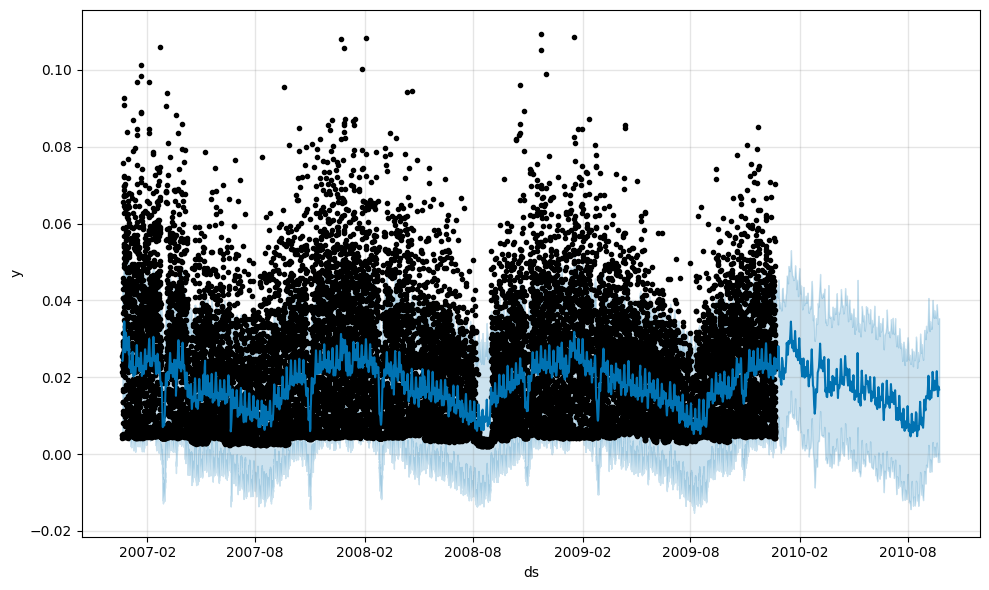

In [146]:
forecast_seasons = model_seasons.predict(future_seasons)
fig_seasons_1 = model_seasons.plot(forecast_seasons)

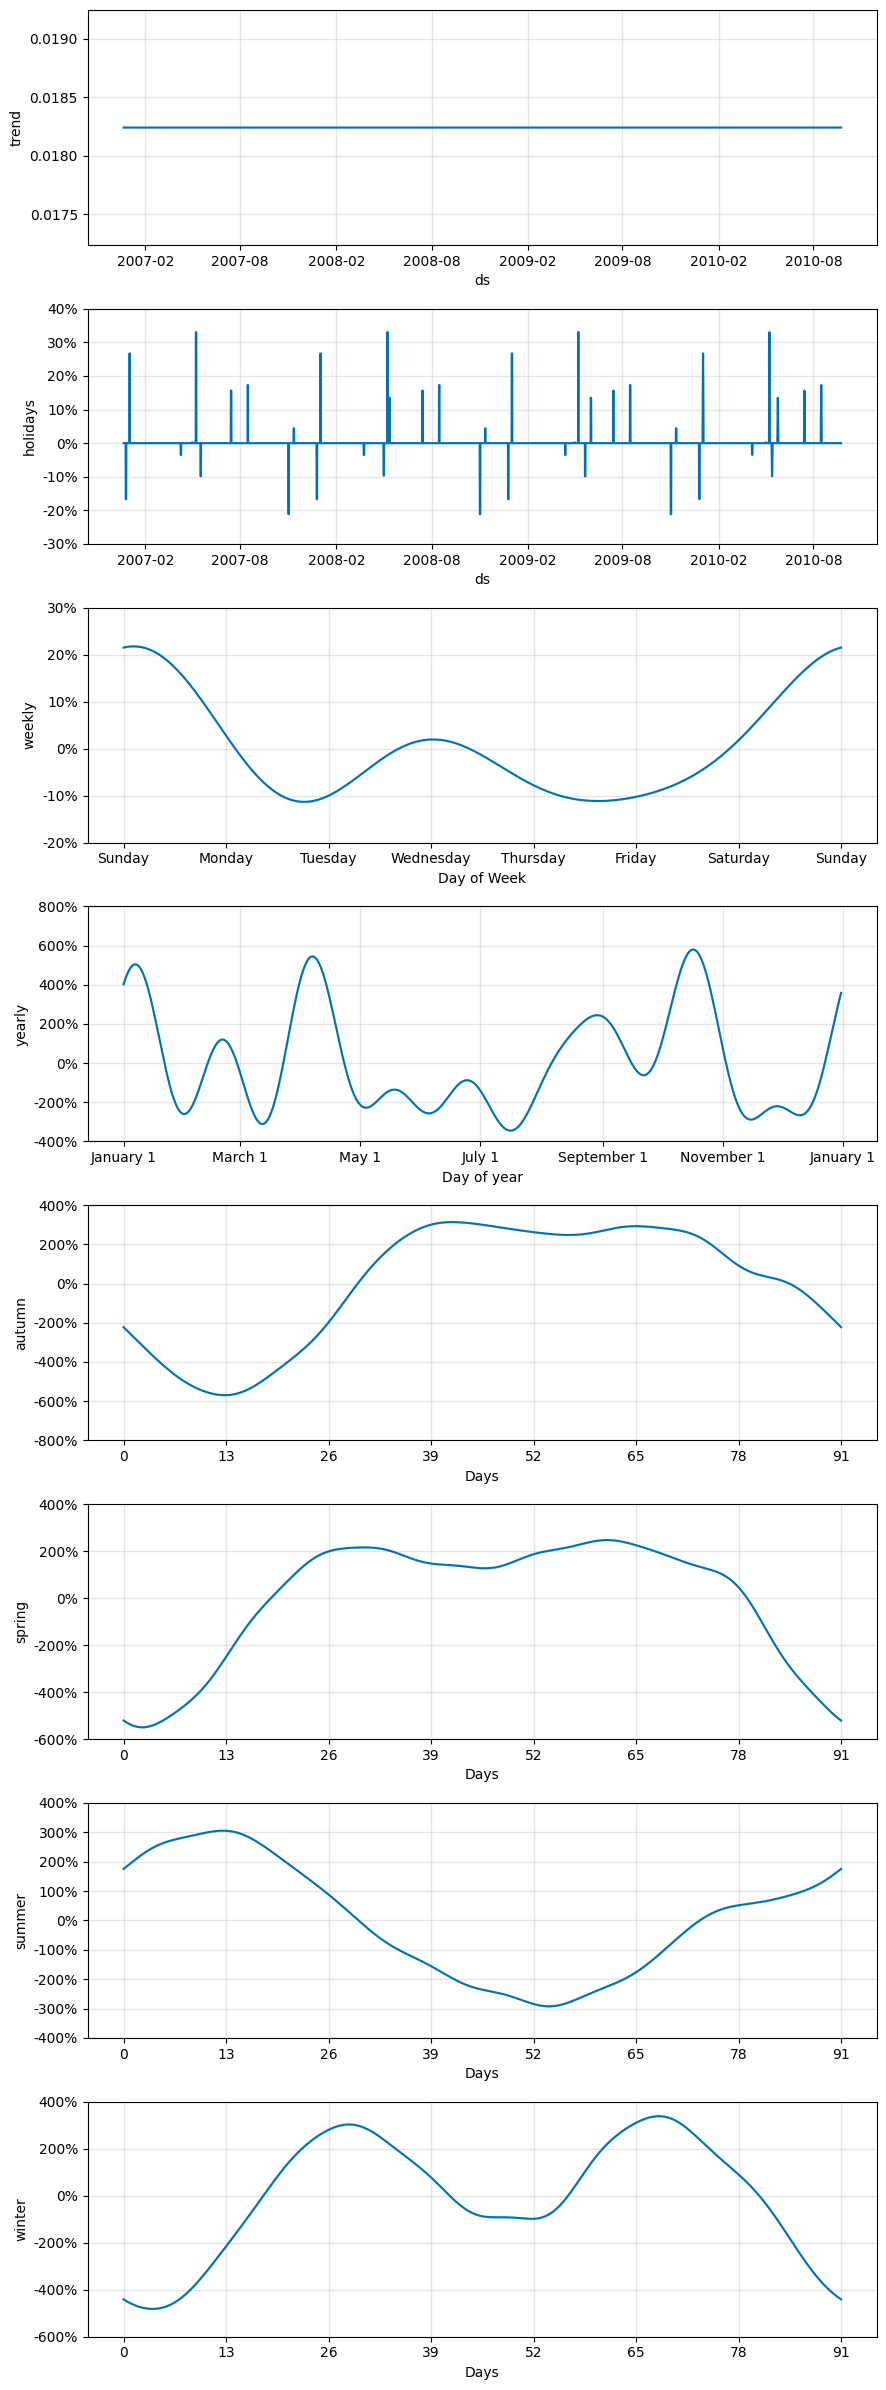

In [147]:
fig_seasons_2 = model_seasons.plot_components(forecast_seasons)

In [148]:
forecast_seasons[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26598,2010-09-18 23:00:00,0.021581,0.003013,0.038989
26599,2010-09-19 23:00:00,0.017953,0.000700,0.036670
26600,2010-09-20 23:00:00,0.015062,-0.002054,0.033935
26601,2010-09-21 23:00:00,0.017552,0.000182,0.035338
26602,2010-09-22 23:00:00,0.016826,-0.002028,0.035358


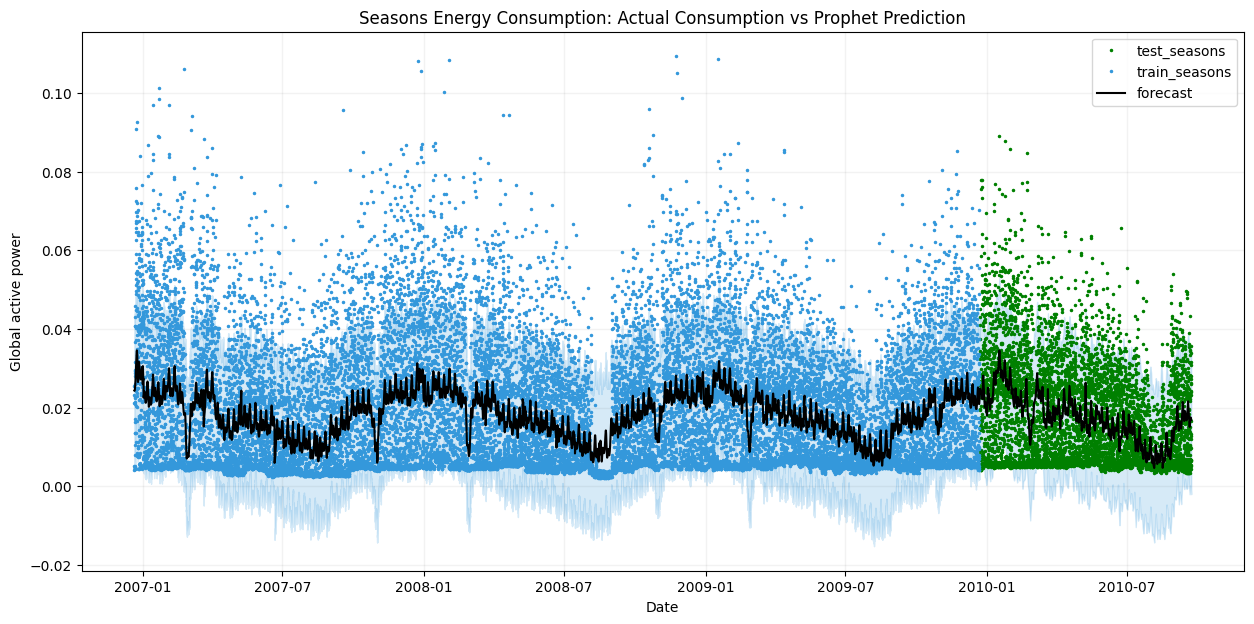

In [149]:
fig_seasons_3 = plt.gcf()
fig_seasons_3.set_size_inches(15, 7)
plt.plot(test_seasons.ds, test_seasons.y, '.', markersize=3, color='green', label = "test_seasons")
plt.plot(train_seasons.ds, train_seasons.y, '.', markersize=3, color='#3498db', label = "train_seasons")
plt.plot(forecast_seasons.ds, forecast_seasons.yhat, color='black', label = "forecast")
plt.fill_between(forecast_seasons.ds, forecast_seasons.yhat_lower, forecast_seasons.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Seasons Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date')
plt.legend()
plt.show()

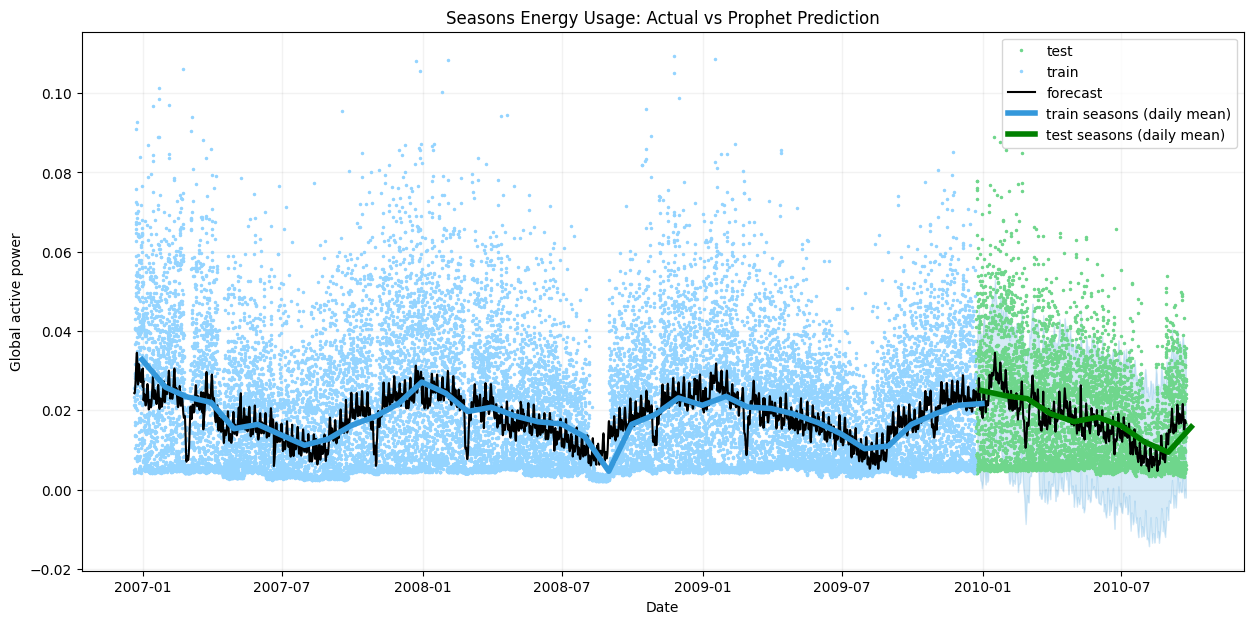

In [150]:
fig_seasons_4 = plt.gcf()
fig_seasons_4.set_size_inches(15, 7)
#a = add_changepoints_to_plot(fig.gca(), m_seasons, forecast_seasons)
plt.plot(test_seasons.ds, test_seasons.y, '.', markersize=3, color='#6fd68c', label = "test")
plt.plot(train_seasons.ds, train_seasons.y, '.', markersize=3, color='#94d4ff', label = "train")
plt.plot(forecast_seasons.ds, forecast_seasons.yhat, color='black', label = "forecast")
plt.plot(train_seasons_mean.ds, train_seasons_mean.y, '-', linewidth=4, color='#3498db', label = "train seasons (daily mean)")
plt.plot(test_seasons_mean.ds, test_seasons_mean.y, '-', linewidth=4, color='green', label = "test seasons (daily mean)")
plt.fill_between(forecast_seasons.ds[-273:], forecast_seasons.yhat_lower[-273:], forecast_seasons.yhat_upper[-273:], color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Seasons Energy Usage: Actual vs Prophet Prediction')
plt.xlabel('Date')
plt.legend()
plt.show()

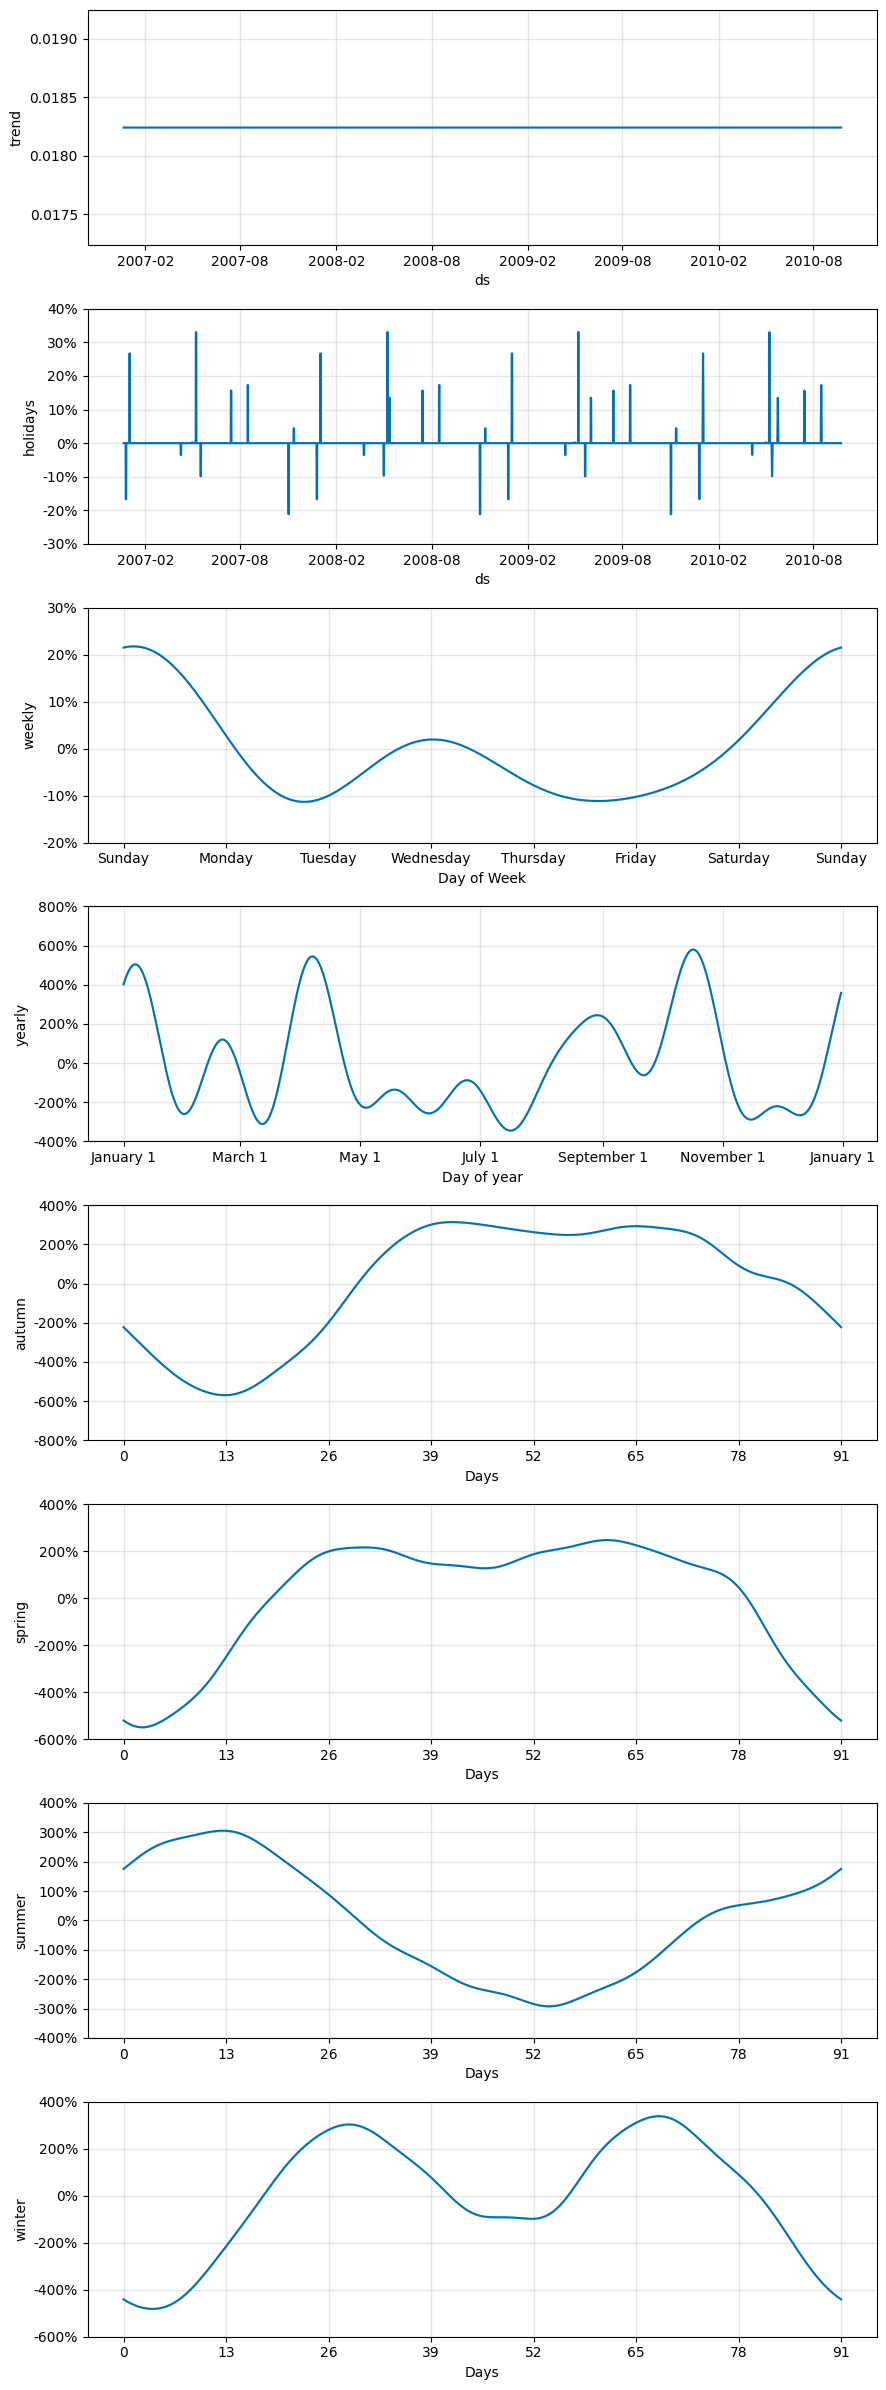

In [167]:
fig_seasons_4 = model_seasons.plot_components(forecast_seasons)

In [151]:
cv_season = cross_validation(model_seasons, 
                             horizon='90 days', 
                             period='30 days',
                             initial='540 days', 
                             parallel='processes')

In [152]:
#df_seasons_D['cutoff'] = df_seasons_D['ds']

cv_season_prfm = performance_metrics(cv_season)
cv_season_prfm.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.000178,0.013356,0.010559,1.126586,0.612181,0.669715,0.860532
1,9 days 01:00:00,0.000179,0.013366,0.010574,1.129980,0.613021,0.670923,0.860532
2,9 days 02:00:00,0.000179,0.013377,0.010588,1.133909,0.615341,0.672183,0.860532
3,9 days 03:00:00,0.000179,0.013388,0.010603,1.138079,0.617868,0.673538,0.860243
4,9 days 04:00:00,0.000179,0.013397,0.010614,1.141394,0.619761,0.674388,0.859954


In [168]:
cv_season_prfm.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
1940,89 days 20:00:00,0.000228,0.015099,0.012228,1.243199,0.661890,0.740009,0.825231
1941,89 days 21:00:00,0.000226,0.015030,0.012202,1.243881,0.660786,0.739791,0.824942
1942,89 days 22:00:00,0.000226,0.015019,0.012192,1.243848,0.660786,0.739564,0.825521
1943,89 days 23:00:00,0.000226,0.015031,0.012197,1.244436,0.661890,0.739721,0.825231
1944,90 days 00:00:00,0.000224,0.014978,0.012157,1.241873,0.658680,0.738088,0.826100


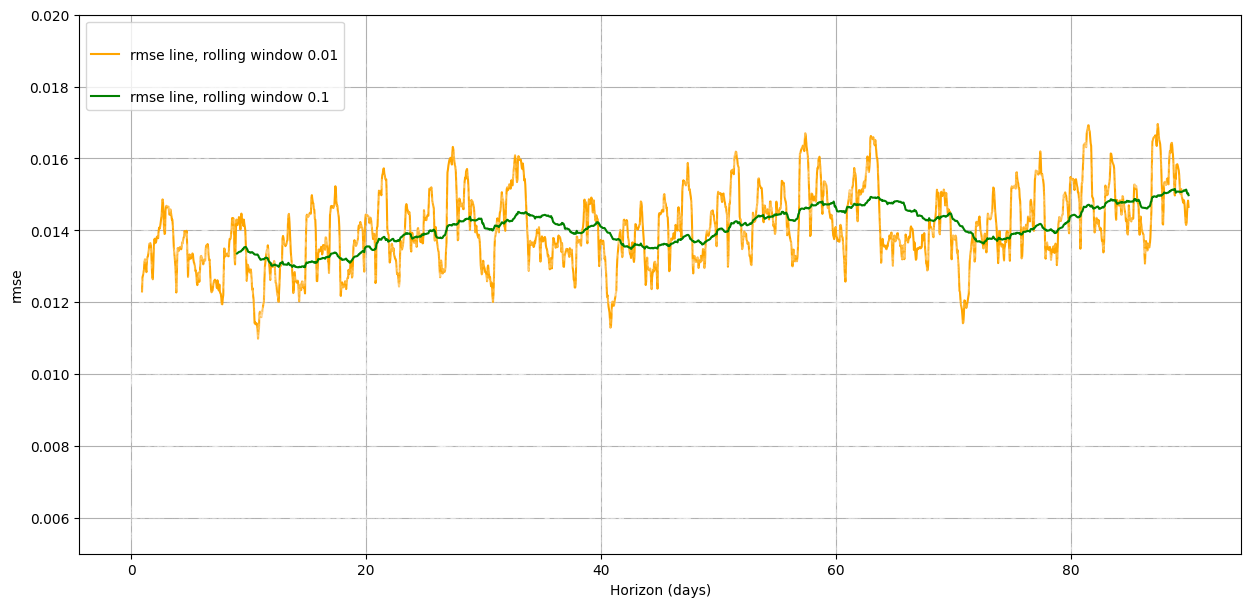

In [166]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

plot_cross_validation_metric(cv_season,
                             metric='rmse',
                             rolling_window=0.01,
                             color='orange',
                             point_color='white',#point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(cv_season,
                             metric='rmse',
                             rolling_window=0.1,
                             color='green',
                             point_color='white',#point_color='#94d4ff',
                             ax=ax)
plt.ylim(top=0.02, bottom=0.005)
plt.legend(['', #'rmse H points, rolling window 0.01',
            'rmse line, rolling window 0.01', 
            '', #'rmse H points, rolling window 0.1', 
            'rmse line, rolling window 0.1'])
plt.show()

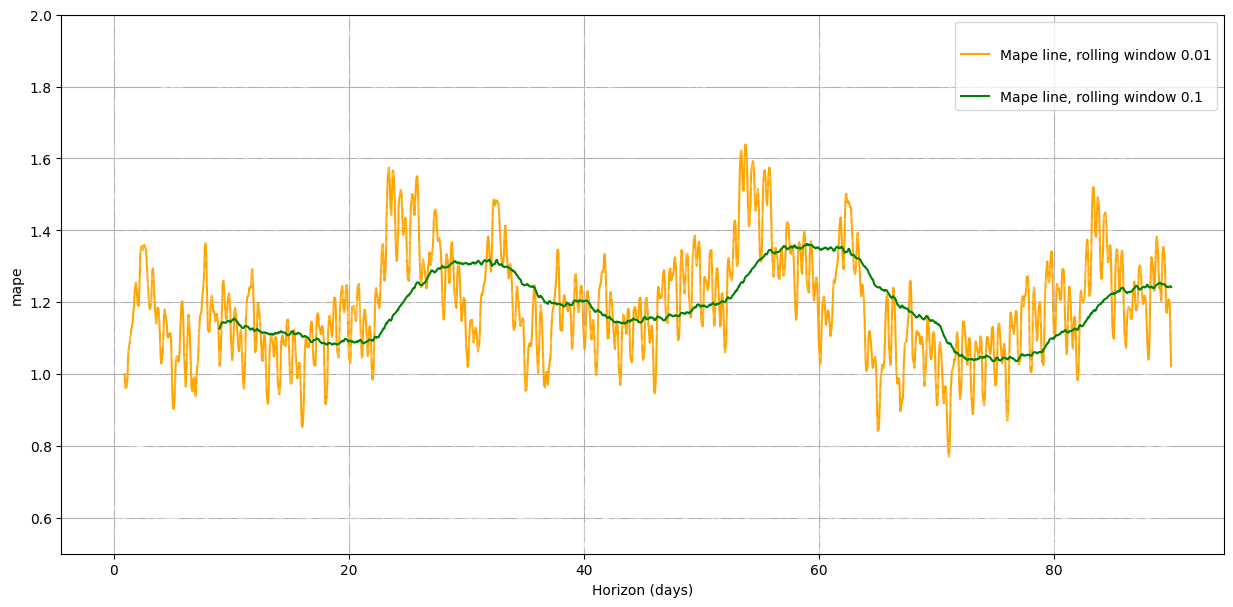

In [165]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plot_cross_validation_metric(cv_season,
                             metric='mape',
                             rolling_window=0.01,
                             color='orange',
                             point_color='white',#point_color='#94d4ff',
                             ax=ax)
plot_cross_validation_metric(cv_season,
                             metric='mape',
                             rolling_window=0.1,
                             color='green',
                             point_color='white',#point_color='#94d4ff',
                             ax=ax)
plt.ylim(top=2, bottom=0.5)
plt.legend(['', #'rmse H points, rolling window 0.01',
            'Mape line, rolling window 0.01', 
            '', #'rmse H points, rolling window 0.1', 
            'Mape line, rolling window 0.1'])
plt.show()